#### <center> Predicting and Preventing Theme Park Incidents Using Machine Learning </center>
#### <center> Miles A. Peña </center>
#### <center> April 6, 2025 </center>

#### Data Sources and Preparation

In [1]:
import pandas as pd
import os

In [2]:
# load the data
file_path = "/Users/milespena/Desktop/Attraction Incidents and Weather Data Orlando 2002-2022.xlsx"
df_incidents = pd.read_excel(file_path, sheet_name = "AttractionIncidents")
df_weather = pd.read_excel(file_path, sheet_name = "OrlandoWeather")

In [3]:
# convert dates to datetime format
df_incidents['Incident Date'] = pd.to_datetime(df_incidents['Incident Date'])
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

In [4]:
# merge datasets on matching dates
df_merged = pd.merge(df_incidents, df_weather, left_on = 'Incident Date', right_on = 'Date', how = 'left')

In [5]:
# preview merged data
df_merged.head()

,Incident Date,Company,Theme Park,Attraction Name,Incident Description,Age,Gender,Date,Precipitation,Max Temperature,Min Temperature,Mean Temperature
0,2002-01-04,Walt Disney World Resort,Hollywood Studios,The Twilight Zone Tower of Terror,"anxiety & claustrophobia, atrial fibrilation",47,Female,2002-01-04,0.00,50.0,31.0,40.5
1,2002-02-10,Universal Studios Orlando,Islands of Adventure,Dudley Do Rights Ripsaw Falls,Complained of lower back pain.,55,Female,2002-02-10,0.45,76.0,60.0,68.0
2,2002-03-22,Universal Studios Orlando,Universal Studios Orlando,E.T Adventure,Injured right foot.,13,Male,2002-03-22,0.00,77.0,56.0,66.5
3,2002-03-29,Walt Disney World Resort,Typhoon Lagoon,Surf Pool,C/o neck pain,16,Female,2002-03-29,0.00,86.0,60.0,73.0
4,2002-07-07,Walt Disney World Resort,Epcot,Spaceship Earth,Asthma attack,51,Male,2002-07-07,0.28,89.0,72.0,80.5


#### Exploratory Data Analysis (EDA)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# incidents per year
df_merged['Year'] = df_merged['Incident Date'].dt.year
incident_counts = df_merged['Year'].value_counts().sort_index()

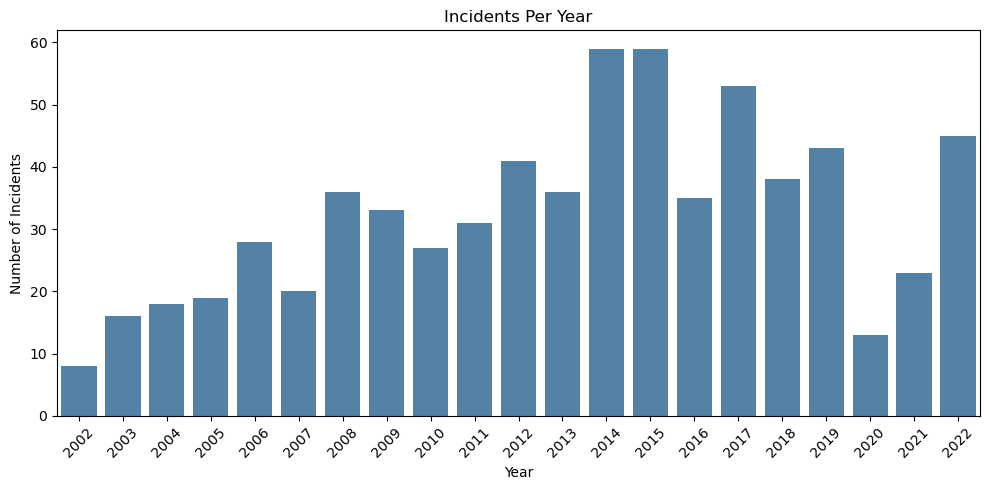

In [8]:
plt.figure(figsize = (10,5))
sns.barplot(x = incident_counts.index, y = incident_counts.values, color = "steelblue")
plt.title("Incidents Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

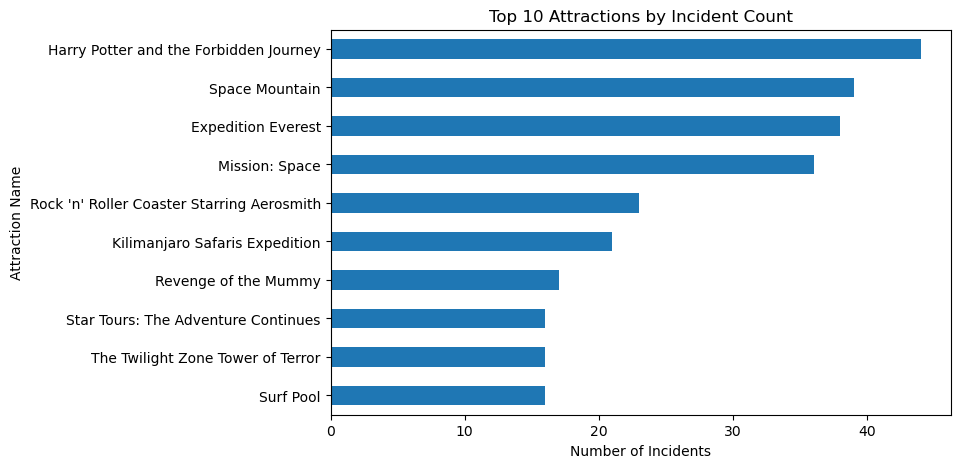

In [9]:
# top 10 attractions by incident count
top_attractions = df_merged['Attraction Name'].value_counts().head(10)
top_attractions.plot(kind = 'barh', title = 'Top 10 Attractions by Incident Count', figsize = (8,5))
plt.xlabel("Number of Incidents")
plt.gca().invert_yaxis()
plt.show()

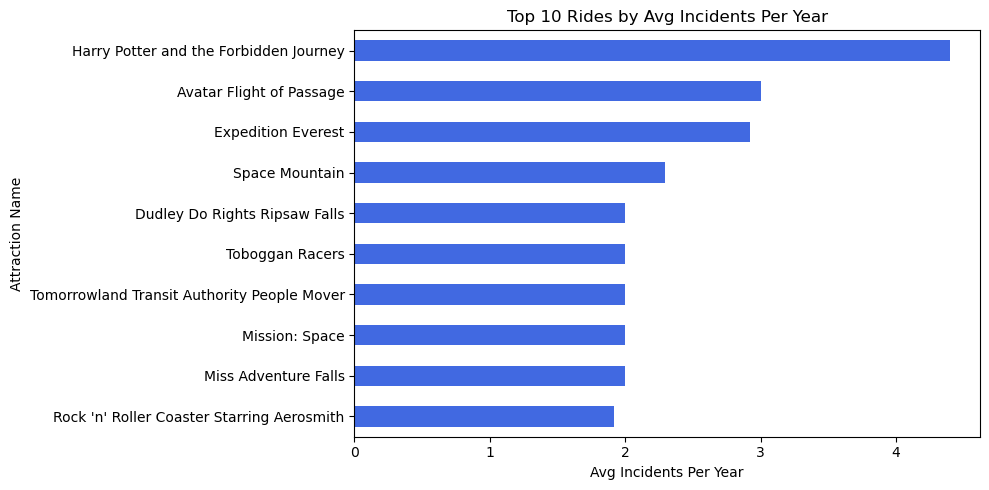

In [10]:
# compute yearly average incidents per ride
ride_year_avg = df_merged.groupby(['Attraction Name', 'Year']).size().reset_index(name = 'Count')
ride_avg = ride_year_avg.groupby('Attraction Name')['Count'].mean().sort_values(ascending = False).head(10)

# plot
ride_avg.plot(kind = 'barh', figsize = (10, 5), color = 'royalblue')
plt.title("Top 10 Rides by Avg Incidents Per Year")
plt.xlabel("Avg Incidents Per Year")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Extreme Weather Analysis

In [11]:
# group by date to count daily incidents
daily_incidents = df_merged.groupby('Incident Date').size().reset_index(name = 'Incident Count')

# merge with weather
weather_daily = df_weather.rename(columns = {"Date": "Incident Date"})
df_weathered = pd.merge(weather_daily, daily_incidents, on = 'Incident Date', how ='left')

# fill 0 for days with no incidents
df_weathered['Incident Count'] = df_weathered['Incident Count'].fillna(0)
df_weathered['Incident Day'] = (df_weathered['Incident Count'] > 0).astype(int)

# compare average weather conditions
incident_weather_avg = df_weathered[df_weathered['Incident Day'] == 1][['Mean Temperature', 'Precipitation']].mean()
nonincident_weather_avg = df_weathered[df_weathered['Incident Day'] == 0][['Mean Temperature', 'Precipitation']].mean()

print("Average weather on INCIDENT days:\n", incident_weather_avg)
print("\nAverage weather on NON-incident days:\n", nonincident_weather_avg)

Average weather on INCIDENT days:
 Mean Temperature    74.477589
Precipitation        0.119769
dtype: float64

Average weather on NON-incident days:
 Mean Temperature    73.494361
Precipitation        0.128024
dtype: float64


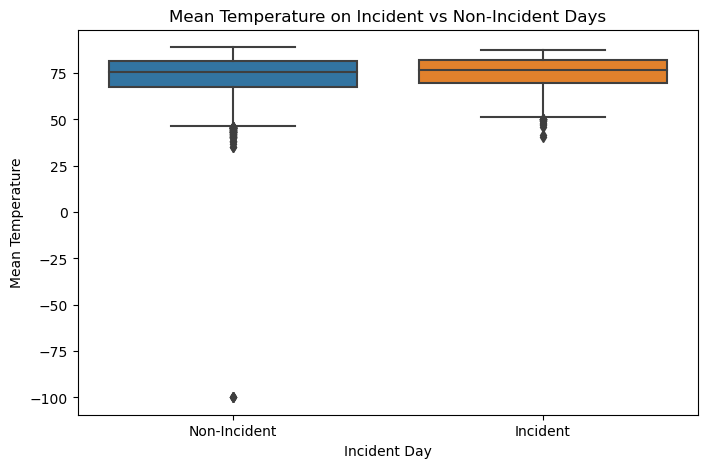

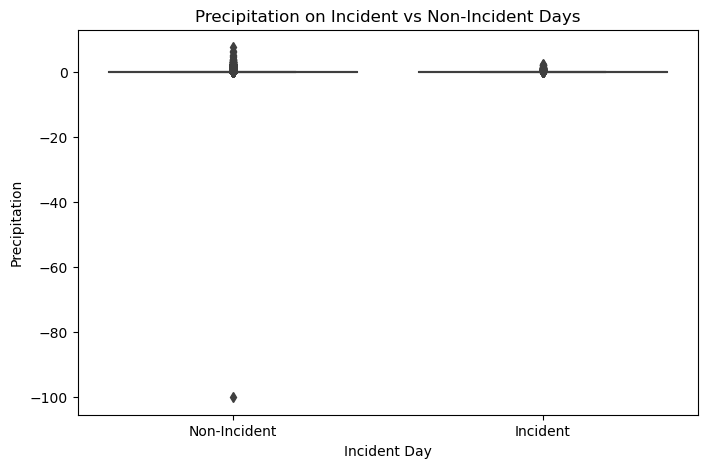

In [12]:
# boxplot: Temperature
plt.figure(figsize = (8,5))
sns.boxplot(x = 'Incident Day', y = 'Mean Temperature', data = df_weathered)
plt.title("Mean Temperature on Incident vs Non-Incident Days")
plt.xticks([0, 1], ['Non-Incident', 'Incident'])
plt.show()

# boxplot: Precipitation
plt.figure(figsize = (8,5))
sns.boxplot(x = 'Incident Day', y = 'Precipitation', data = df_weathered)
plt.title("Precipitation on Incident vs Non-Incident Days")
plt.xticks([0, 1], ['Non-Incident', 'Incident'])
plt.show()

In [13]:
# What’s the top 10% hottest days?
temp_threshold = df_weathered['Mean Temperature'].quantile(0.90)
hot_days = df_weathered[df_weathered['Mean Temperature'] >= temp_threshold]

# What % of total incidents happened on those days?
hot_incidents = hot_days['Incident Count'].sum()
total_incidents = df_weathered['Incident Count'].sum()

print(f"Incidents on the hottest 10% of days: {hot_incidents} out of {int(total_incidents)} ({hot_incidents / total_incidents:.2%})")

Incidents on the hottest 10% of days: 102.0 out of 681 (14.98%)


In [14]:
precip_threshold = df_weathered['Precipitation'].quantile(0.90)
wet_days = df_weathered[df_weathered['Precipitation'] >= precip_threshold]

wet_incidents = wet_days['Incident Count'].sum()
total_incidents = df_weathered['Incident Count'].sum()
wet_incident_pct = wet_incidents / total_incidents * 100

print(f"\nIncidents on the wettest 10% of days: {wet_incidents} out of {int(total_incidents)} ({wet_incident_pct:.2f}%)")


Incidents on the wettest 10% of days: 66.0 out of 681 (9.69%)


In [15]:
from scipy.stats import ttest_ind

incident_days = df_weathered[df_weathered['Incident Day'] == 1]['Mean Temperature']
nonincident_days = df_weathered[df_weathered['Incident Day'] == 0]['Mean Temperature']

t_stat, p_val = ttest_ind(incident_days, nonincident_days, equal_var=False)
print(f"T-statistic: {t_stat:.2f}, P-value: {p_val:.4f}")

T-statistic: 2.56, P-value: 0.0105


#### NLP (TF-IDF and Keyword Analysis)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
# drop missing descriptions and convert to lowercase
descriptions = df_merged['Incident Description'].dropna().str.lower()

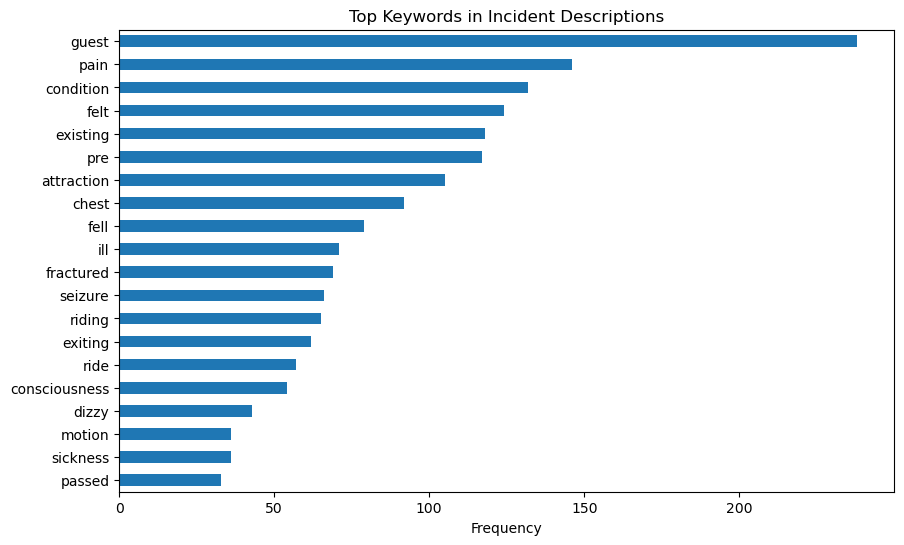

In [18]:
# count most frequent words
vectorizer = CountVectorizer(stop_words = 'english', max_features = 20)
X = vectorizer.fit_transform(descriptions)
word_freq = pd.Series(X.toarray().sum(axis = 0), index = vectorizer.get_feature_names_out())
word_freq.sort_values(ascending = True).plot(kind = 'barh', figsize = (10, 6), title = 'Top Keywords in Incident Descriptions')
plt.xlabel("Frequency")
plt.show()

#### Predictive Modeling

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [20]:
# label 'severe' based on keywords
df_merged['Severe'] = df_merged['Incident Description'].str.contains(
    'seizure|conciousness|fainted|cardiac|chest pain|collapse|died|passed away', case = False, na = False
).astype(int)

In [21]:
# encode categorical variables
df_model = df_merged[['Attraction Name', 'Theme Park', 'Mean Temperature', 'Severe']].dropna()
df_model = pd.get_dummies(df_model, columns = ['Attraction Name', 'Theme Park'], drop_first = True)

In [22]:
# train/test split
X = df_model.drop('Severe', axis = 1)
y = df_model['Severe']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [23]:
# train model
clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
# evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       100
           1       0.50      0.35      0.41        37

    accuracy                           0.73       137
   macro avg       0.64      0.61      0.62       137
weighted avg       0.71      0.73      0.71       137



#### Time Series Forecasting

22:25:47 - cmdstanpy - INFO - Chain [1] start processing
22:25:47 - cmdstanpy - INFO - Chain [1] done processing


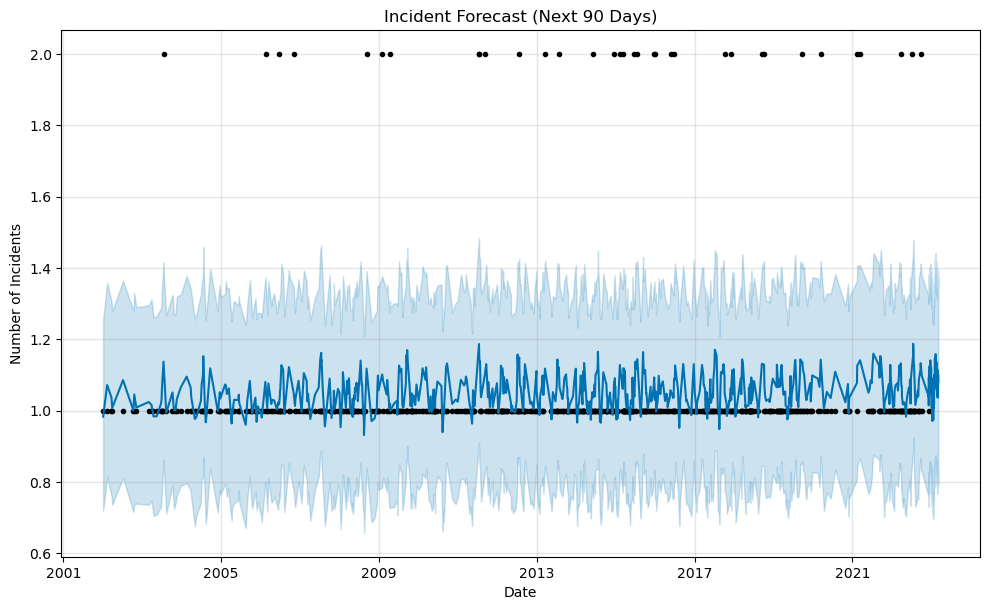

In [25]:
from prophet import Prophet

# prepare daily incident data
incident_ts = df_merged.groupby('Incident Date').size().reset_index(name = 'y')
incident_ts.rename(columns = {'Incident Date': 'ds'}, inplace = True)

# fit Prophet model
model = Prophet()
model.fit(incident_ts)

# create future dataframe and predict
future = model.make_future_dataframe(periods = 90)
forecast = model.predict(future)

# plot forecast
fig1 = model.plot(forecast)
plt.title("Incident Forecast (Next 90 Days)")
plt.xlabel("Date")
plt.ylabel("Number of Incidents")
plt.show()